<a href="https://colab.research.google.com/github/Talevin12/Kaggle-ML-Titanic/blob/main/Tal_Levin_titanic_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Name:** Tal Levin

**ID:** 314920505

**Kaggle User:** https://www.kaggle.com/tallevin12/account


This will be my model for the "Titanic - Machine Learning from disaster" Kaggle competition.

The goal is to predict in the most accurate way which passenger survived the disaster.

My plan for this challenge:

- Look at the data and draw as many conclusions from it as possible

- Remove features if it doesn't have nothing to do with the target value prediction

- Add features that can help increase the accuracy

- Make graphs/ and "play" a little with the data frame to find connections between features or between feature to targer, make conclusions and maybe add/change features

- Validation test all I did on a model (Logistic Regression or MLP) that will work the best on this data (test on validaion data)

# **Imports**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn import model_selection
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import metrics
from sklearn import pipeline
import plotly.express as px

# **Load Data**

In [ ]:
train = pd.read_csv("/content/train.csv")
test  = pd.read_csv("/content/test.csv")

# **Data Investigation**

**Let's look at the data**

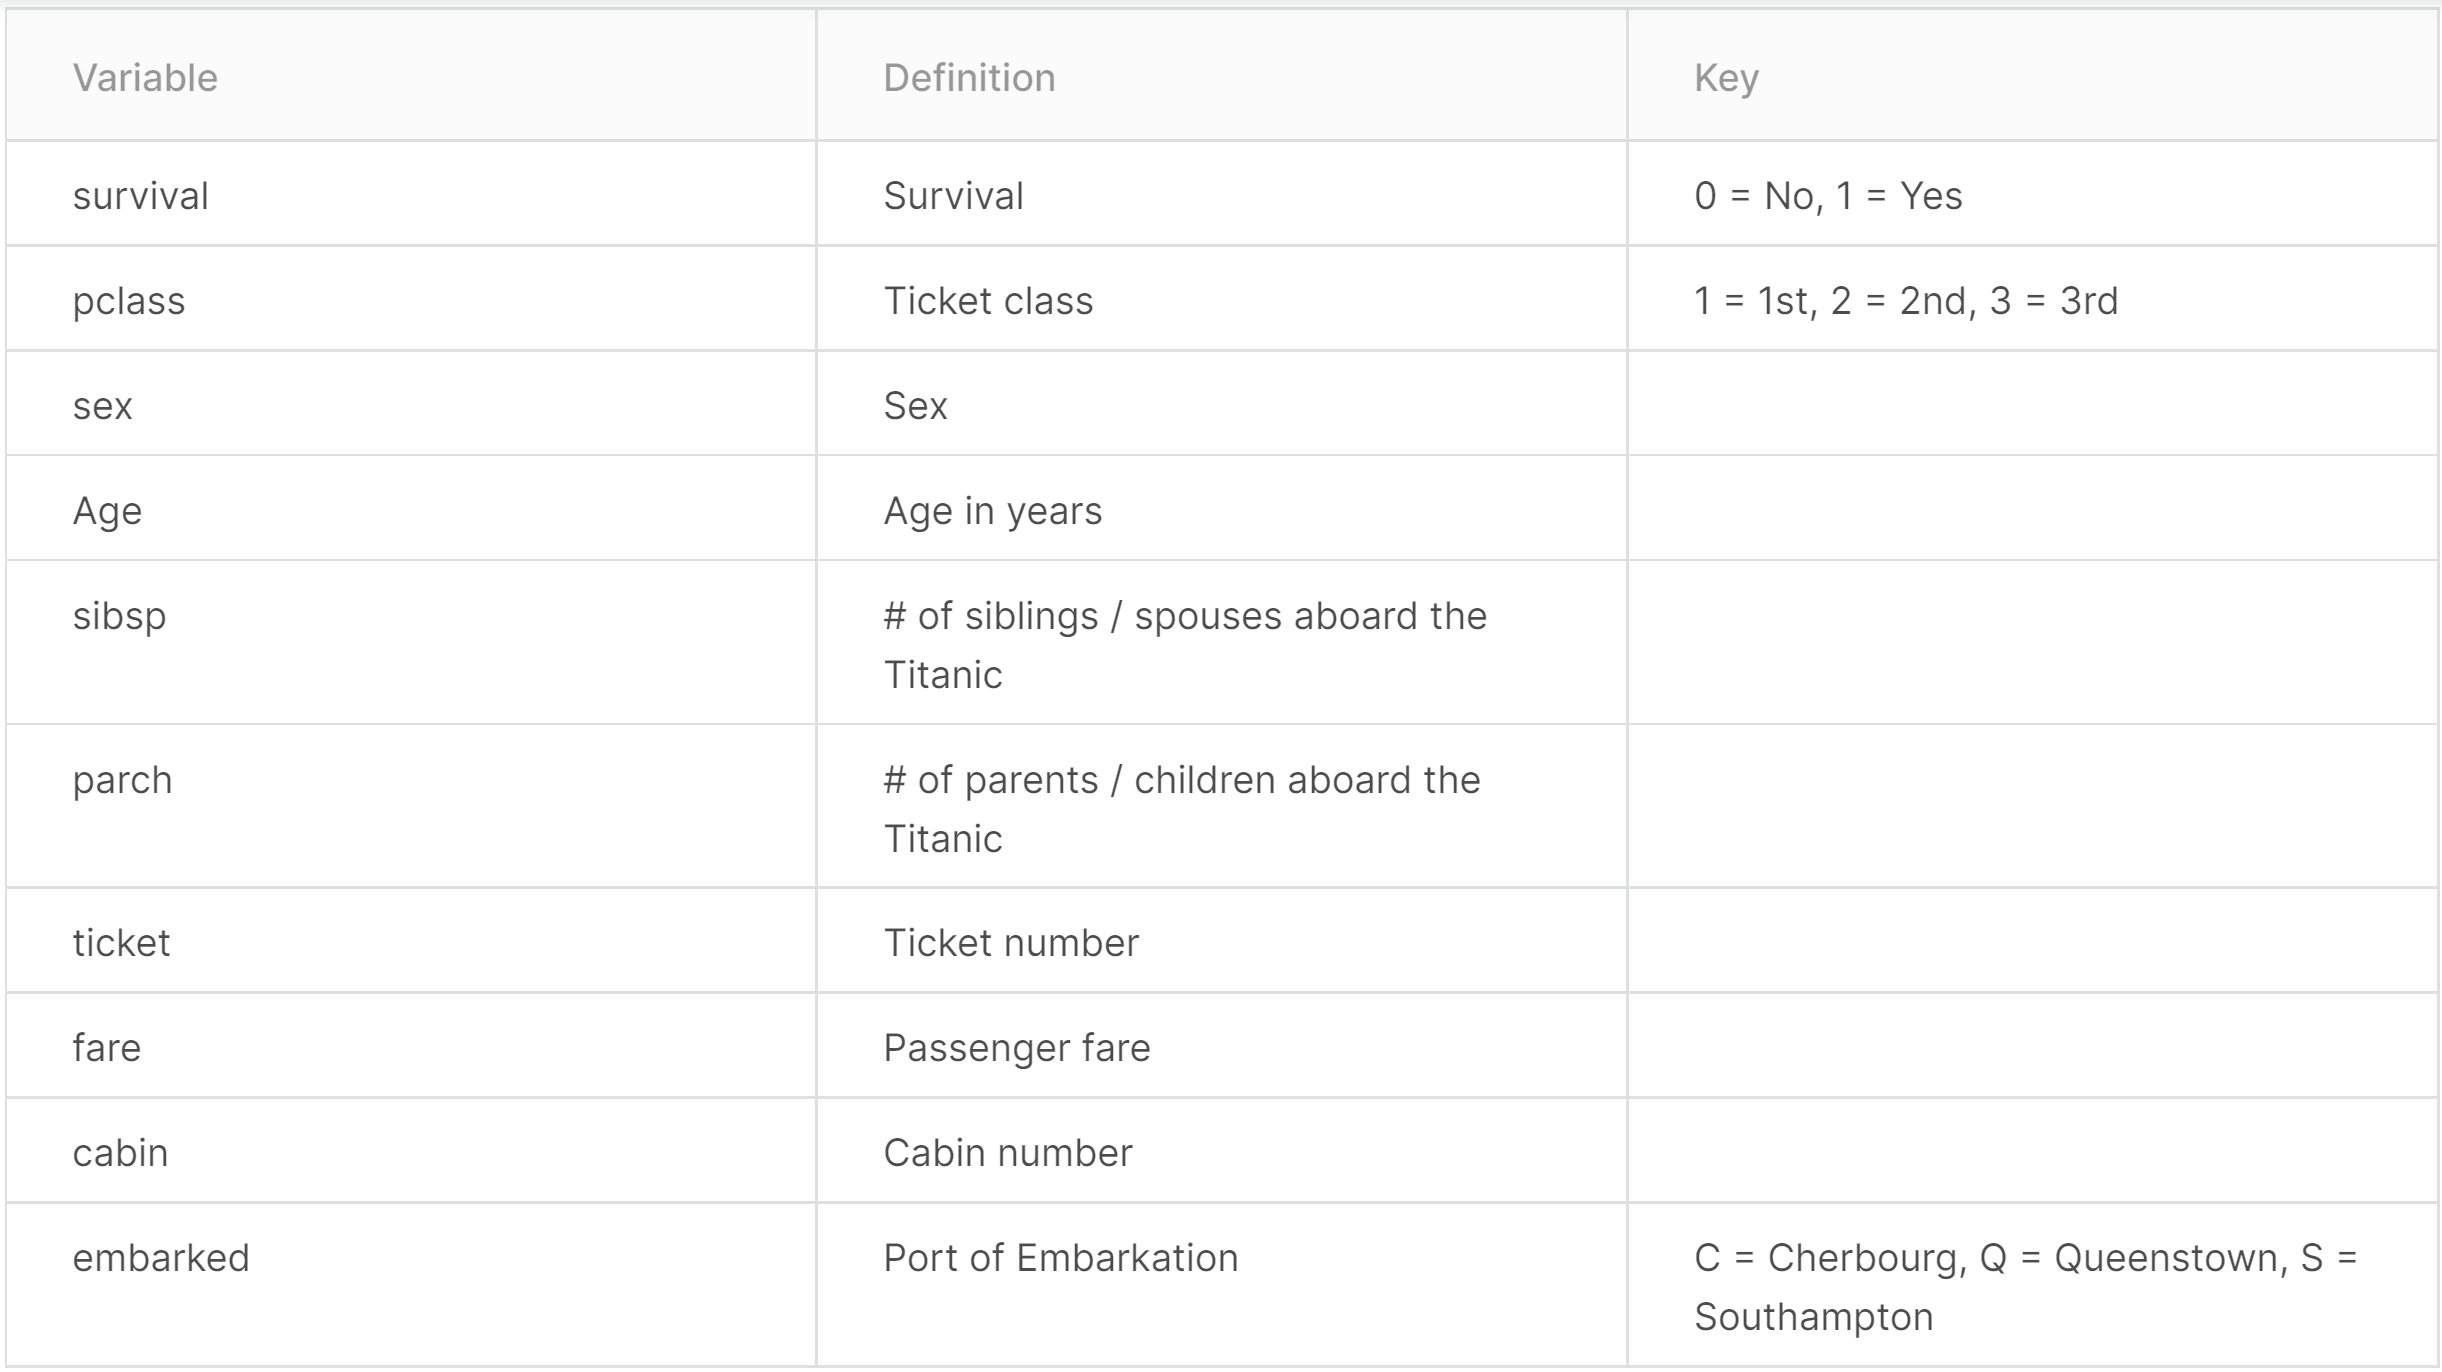

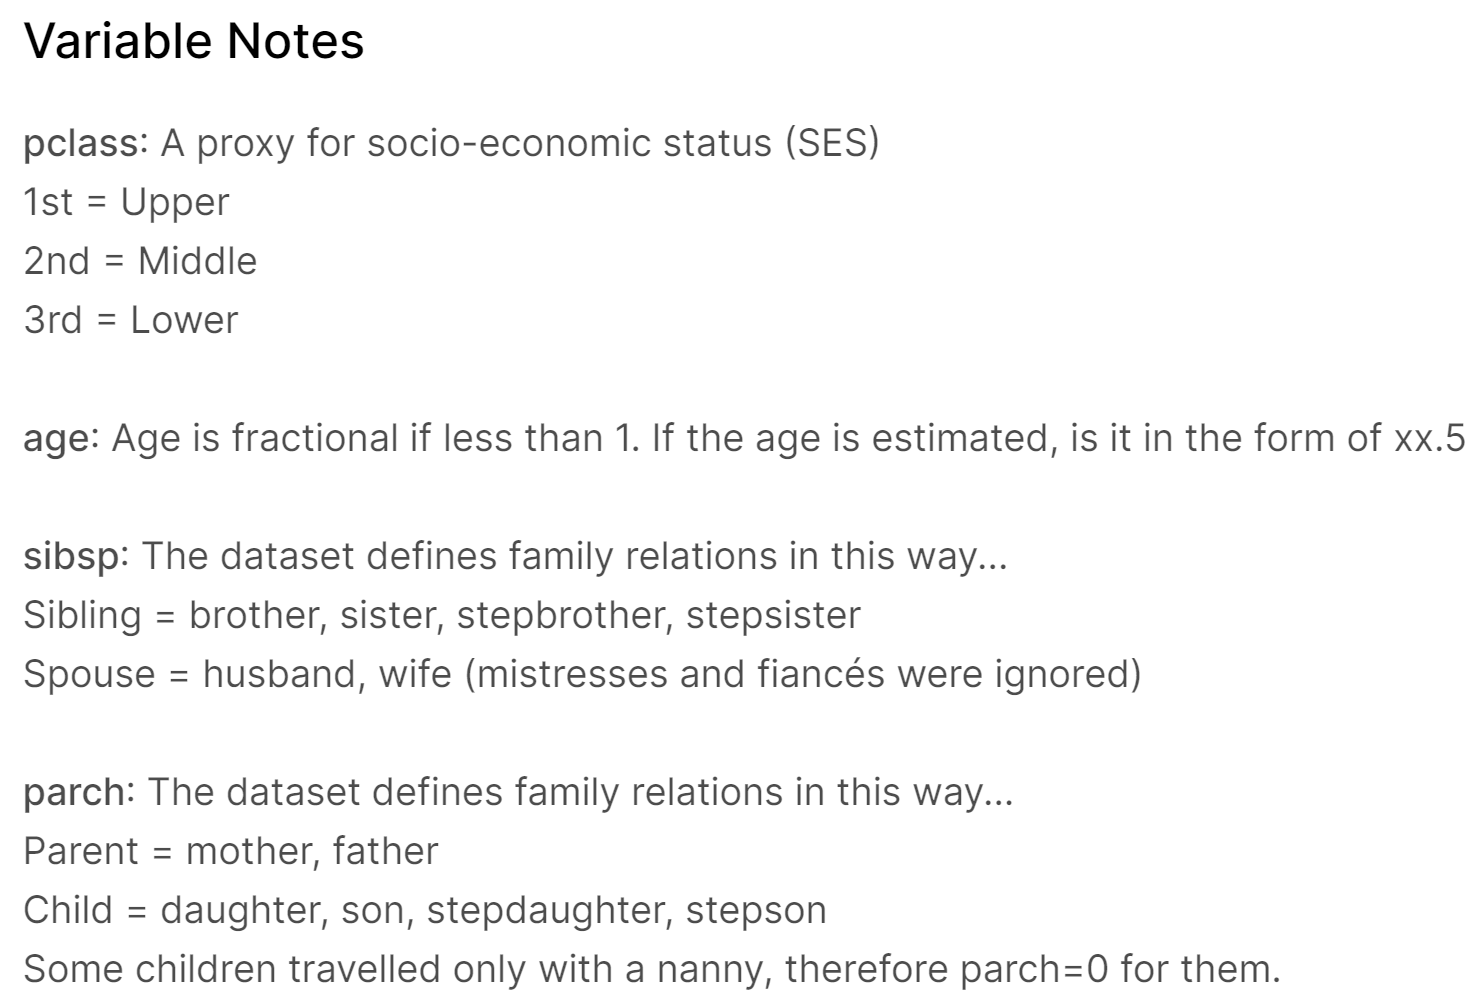

In [ ]:
train_survived = train['Survived']
train.drop('Survived', axis=1, inplace=True)

#I'm adding a new column to let me seperate the train data from the test data later. I'll remove this column later.
train["is_train"] = 1
test["is_train"] = 0

combined_data = pd.concat([train, test])

combined_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_train
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,0
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


Checking for missing values

In [ ]:
combined_data.isna().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
is_train          0
dtype: int64

Some insights:
- It looks like almost all of the cabin values are missing :(
- Some age values are missing
- Just one fare value is missing (It's a passenger data from the test dataset so I'll have to fill this value)
- Just two embarked values are missing so I'll remove these two rows

# A quick look at the data dictionary :)

PassengerId has nothing to do with the target value 'Survived'. I'll remove this feature.

In [ ]:
combined_data.drop('PassengerId', axis=1, inplace=True)

Removing the Cabin column

In [ ]:
combined_data.drop('Cabin', axis=1, inplace=True)

Filling the Fare (And afterward the age) values

In [ ]:
def fill_na_mean(df, column_name, value = None):
    df_not_null = df[~df[column_name].isnull()]
    if value == None:
        df[column_name].fillna(df_not_null[column_name].mean(), inplace=True)
    else:
        df[column_name].fillna(value, inplace=True)

In [ ]:
fill_na_mean(combined_data, 'Fare') #missing in test

na_embarked_lst = combined_data[combined_data['Embarked'].isnull()].index.tolist()
for index in na_embarked_lst:
    train_survived.drop(index = index, inplace=True)
combined_data.dropna(subset = ["Embarked"], inplace=True) #missing in train

Passengers' names contain their title, maybe it will bring more benefit.

In [ ]:
temp1 = combined_data['Name'].str.split(',', expand=True)
temp2 = temp1[1].str.split('.', expand=True)
combined_data['Name_Title'] = temp2[0]

combined_data['Name_Title'].value_counts()

 Mr              757
 Miss            259
 Mrs             196
 Master           61
 Dr                8
 Rev               8
 Col               4
 Ms                2
 Mlle              2
 Major             2
 Lady              1
 Capt              1
 Don               1
 Mme               1
 the Countess      1
 Sir               1
 Jonkheer          1
 Dona              1
Name: Name_Title, dtype: int64

Some titles are equal but in two different languages (English, French):
- mme = mrs
- mlle = miss

Some have similar meanings:
- Sir and Lady (honour)
- Col and Major (Army)
- Don and Dona (old citizens)
- Dr and Capt (Professional)

Some can tell us about the age of the person (many age values are missing):
- Miss (unmerried woman)
- mrs (merried woman)
- Master (under 18 man)
- Don and Dona

Other:
- Rev (officially appointed religious leader)
- Jonkheer ("Young lord")

In [ ]:
combined_data["Name_Title"] = combined_data["Name_Title"].str.replace("Mme", "Mrs")
combined_data["Name_Title"] = combined_data["Name_Title"].str.replace("Mlle", "Miss")

# **Filling the missing age values**

I'm trying to fill the ages correctly by name titles

In [ ]:
null_data = combined_data[combined_data.isnull().any(axis=1)]["Name_Title"]
null_data.value_counts()

 Mr        176
 Miss       50
 Mrs        27
 Master      8
 Ms          1
 Dr          1
Name: Name_Title, dtype: int64

I can fill this value seperatly for each title:
- Mr - mean from men with mr title
- miss - mean from women with miss title
- mrs - mean from women with mrs title
- master - mean from passengers with master title
- ms - mean from women passengers
- Dr - Top quarter of all passengers values

In [ ]:
combined_data['Name_Title'] = combined_data['Name_Title'].str.strip()

for title in combined_data['Name_Title']:
  combined_data.loc[combined_data['Name_Title'].str.match(title) & combined_data['Age'].isna(), ['Age']] = combined_data.loc[combined_data['Name_Title'].str.match(title), ['Age']].mean()[0]


In [ ]:
combined_data.isna().any()

Pclass        False
Name          False
Sex           False
Age           False
SibSp         False
Parch         False
Ticket        False
Fare          False
Embarked      False
is_train      False
Name_Title    False
dtype: bool

**Great :)**

I'm thinking about adding name title as a feature.

Let's see if there is any connection  between name title to survival in the tradegy.

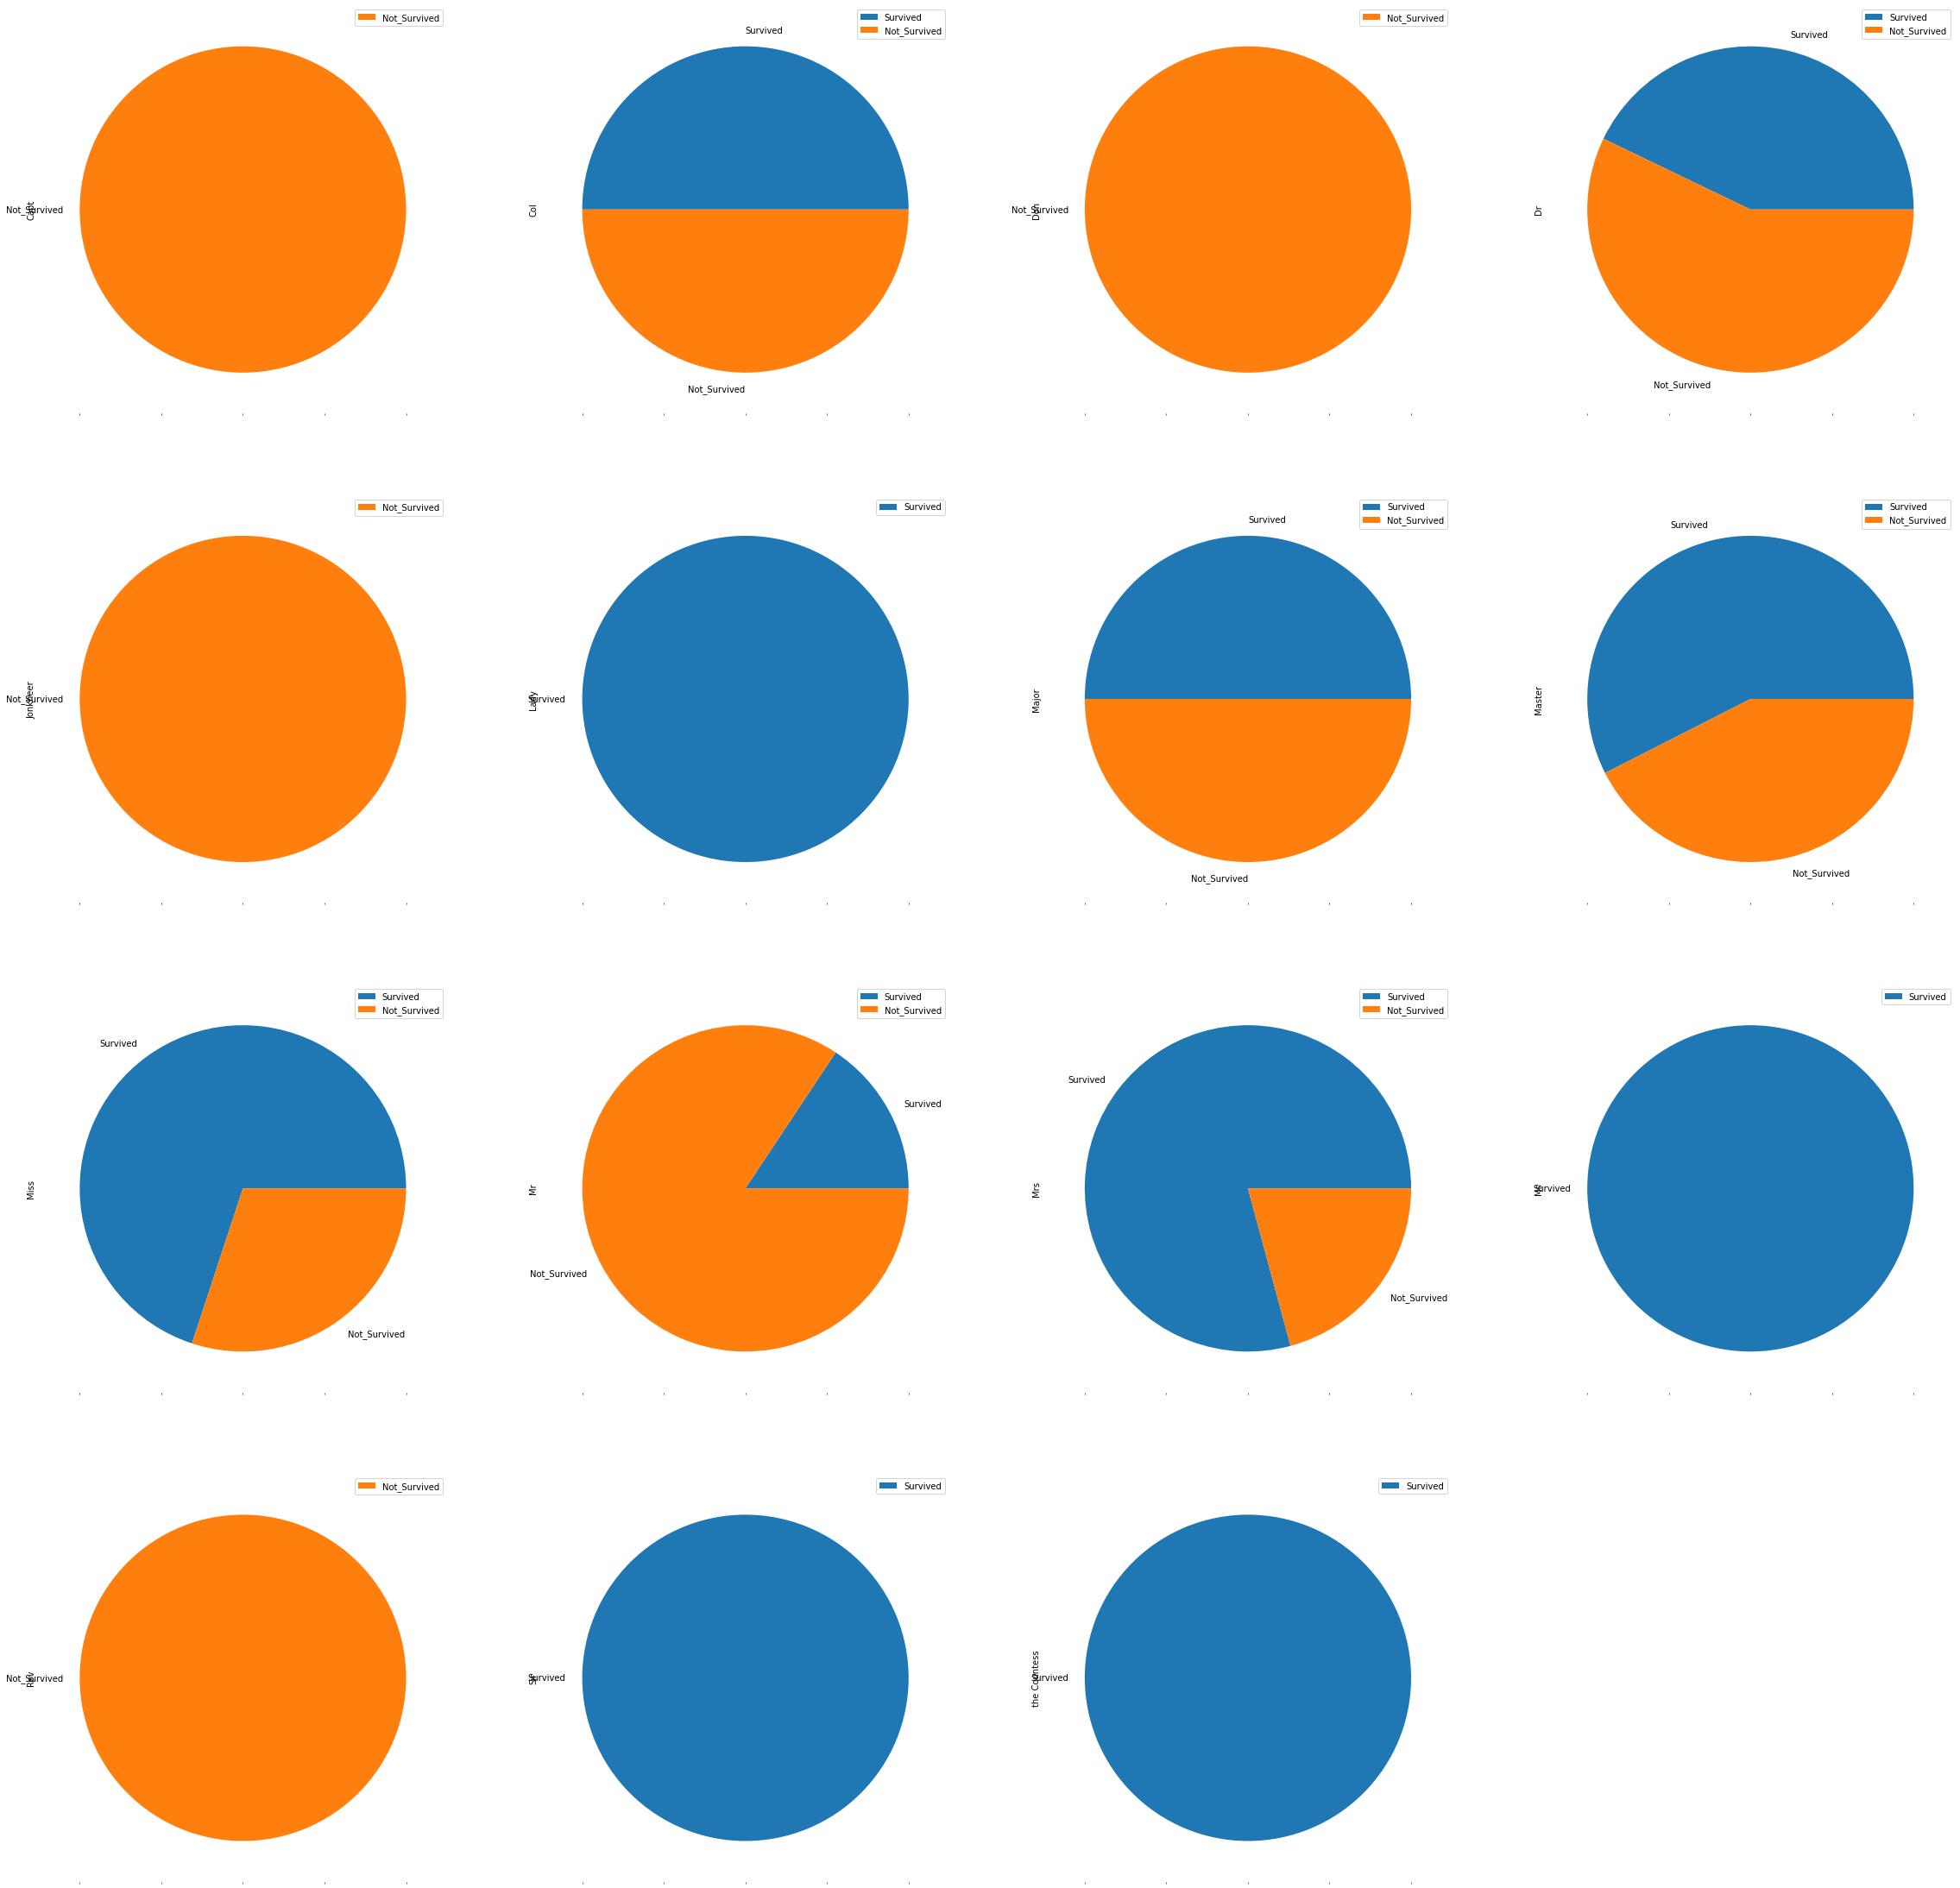

In [ ]:
train_title_col = combined_data.loc[combined_data['is_train'] == 1].Name_Title
title_survived_df = pd.concat({"Name_Title" : train_title_col, "Survived" : train_survived}, axis=1)

grouped_by_title = title_survived_df.groupby(title_survived_df.Name_Title)

plot_df = pd.DataFrame(index=grouped_by_title.groups.keys(), columns=["Survived", "Not_Survived"])
for title, group in grouped_by_title:
  temp_group = group.groupby(group.Survived)

  if 1 in temp_group.groups.keys():
    plot_df["Survived"][title] = temp_group.get_group(1)["Survived"].count()
  else:
    plot_df["Survived"][title] = 0

  if 0 in temp_group.groups.keys():
    plot_df["Not_Survived"][title] = temp_group.get_group(0)["Survived"].count()
  else:
    plot_df["Not_Survived"][title] = 0

plot = plot_df.T.plot.pie(subplots=True, figsize=(40,40), layout = (4,4))



Some insights:
- Women name titles seem to survived more
- Men name titles seem to survived less
- all the reverands not survived

I think, it's a good idea to add this column as a feature.

I'll handle all the encoding later

# Ticket column finding!

In [ ]:
combined_data["Ticket"].value_counts()

CA. 2343        11
CA 2144          8
1601             8
S.O.C. 14879     7
347077           7
                ..
C.A. 29395       1
250650           1
349215           1
2679             1
A/5 21175        1
Name: Ticket, Length: 928, dtype: int64

**As we see here some passengers have identical ticket number. Maybe it can tells us about how many relatives a passenger have with him on the ship? friends?**

**let's find out if a duplicate ticket number have any connection to survival**

In [ ]:
from statistics import mean, median 

train_ticket_col = combined_data.loc[combined_data['is_train'] == 1].Ticket
ticket_survived_df = pd.concat({"Ticket" : train_ticket_col, "Survived" : train_survived}, axis=1)

grouped_by_Ticket = ticket_survived_df.groupby(ticket_survived_df.Ticket)

count = 0
sum = 0
lst = []
for ticket, group in grouped_by_Ticket:
  if group.size > 2:
    res = (group.loc[group.Survived == 1].Survived.count()/group.Survived.count())*100 #Percentage of survival within the same ticket number
    lst.append(res) 

print("mean:", mean(lst), "median:", median(lst)) # mean of percentage -----> looking for mean far from 50

mean: 55.54958825635517 median: 50.0


It looks like there almost no connection between same ticket number to survival.

 I will try to add a feature to represent how much passengers with same ticket number every passenger has and test it on the validation set.

In [ ]:
combined_data["Same_Ticket#"] = 0

res_lst = []
for index,row in combined_data.iterrows():
    res_lst.append(combined_data["Ticket"].value_counts()[row["Ticket"]]-1)
combined_data["Same_Ticket#"] = res_lst

**Dropping columns that I don't neet anymore**

In [ ]:
combined_data.drop("Name", axis=1, inplace=True)
combined_data.drop("Ticket", axis=1, inplace=True)

no_Name_Title_valid = combined_data.drop("Name_Title", axis=1) #try with and without this feature

# Now.. Let's handle the non-numeric and categorical values!
- Sex
- embarked
- Name title

In [ ]:
combined_data = pd.get_dummies(combined_data, columns=['Sex', 'Embarked', 'Name_Title'], prefix=['Sex', 'Embarked', 'Name_Title'], drop_first=True)

no_Name_Title_valid = pd.get_dummies(no_Name_Title_valid, columns=['Sex', 'Embarked'], prefix=['Sex', 'Embarked'], drop_first=True)

# Separating train and test

In [ ]:
train = combined_data[combined_data['is_train'] == 1]
test = combined_data[combined_data['is_train'] == 0]

train_no_title = no_Name_Title_valid[no_Name_Title_valid['is_train'] == 1]
test_no_title = no_Name_Title_valid[no_Name_Title_valid['is_train'] == 0]

train.drop("is_train", axis=1, inplace=True)
test.drop("is_train", axis=1, inplace=True)

train_no_title.drop("is_train", axis=1, inplace=True)
test_no_title.drop("is_train", axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Logistic regression is a technique that can be used for binary classification — making a prediction when the thing to predict can be one of just two possible values.

**Logistic regression would be great in our case.**

In [ ]:
def print_graphs_r2_mse(graph_points):
    index = 1
    title = ""
    for k, v in graph_points.items():
        best_value = max(v.values()) if 'score' in k else min(v.values())
        best_index = np.argmax(list(v.values())) if 'score' in k else np.argmin(list(v.values()))
        color = 'r' if 'train' in k else 'b'

        plt.scatter(list(v.keys()),list(v.values()))
        plt.plot(list(v.keys()), list(v.values()), color=color, label=k)

        title += f'{k}, best value: x={round((best_index + 1)*0.05 +0.05, 2)}, y={best_value}\n'

        plt.xlabel("test size")
        plt.xlim([0.1, 0.9])

        if 'score' in  k:
          plt.ylabel("score")
          plt.ylim([0.78, 0.86])
        else:
          plt.ylabel("loss")
          plt.ylim([4, 7.6])
        
        if index%2 == 0:
          plt.title(title)
          plt.legend(loc='best')
          title = ""
          plt.show()

        index += 1  

def plot_score_and_loss_by_split(X, t):
    graph_points = {
                    'train_loss':{},
                    'val_loss': {},
                    'train_score': {},
                    'val_score': {}
                    }
    for size in range(10, 100, 5):
        X_train, X_val, t_train, t_val = model_selection.train_test_split(X, t, test_size=size/100, random_state=42)
        SGD_cls = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.SGDClassifier(loss='log', alpha=0, learning_rate='constant', eta0=0.01)).fit(X_train, t_train)
        y_train = SGD_cls.predict(X_train)
        y_val = SGD_cls.predict(X_val)
        graph_points['train_loss'][size/100] = metrics.log_loss(t_train, y_train)
        graph_points['val_loss'][size/100] = metrics.log_loss(t_val, y_val)
        graph_points['train_score'][size/100] = SGD_cls.score(X_train, t_train)
        graph_points['val_score'][size/100] = SGD_cls.score(X_val, t_val)

    print_graphs_r2_mse(graph_points)

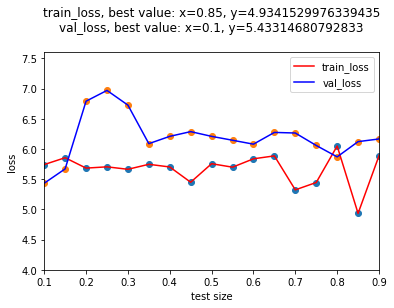

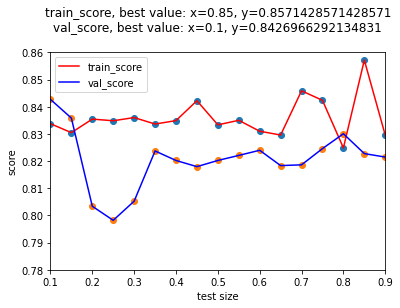

In [ ]:
plot_score_and_loss_by_split(train,train_survived)

I'm searching the right spot where the train loss equals to the val loss:

===> 0.15 test size => loss around 5.8

**Trying without the Same_Ticket# feature**

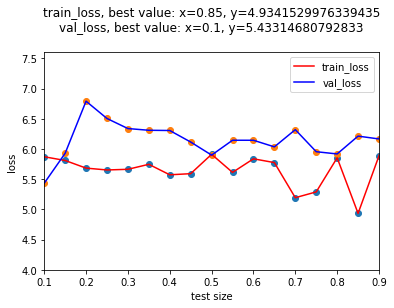

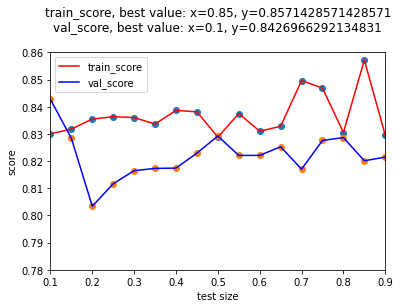

In [ ]:
train_no_same_ticket = train.drop("Same_Ticket#", axis=1)
plot_score_and_loss_by_split(train_no_same_ticket,train_survived)

===> 0.15 test size => loss around 5.9

**Trying without the name title feature**

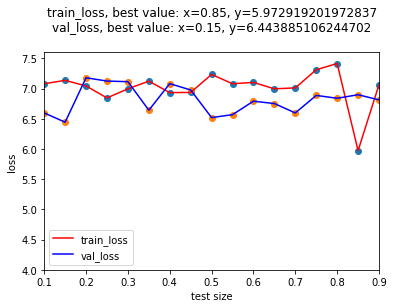

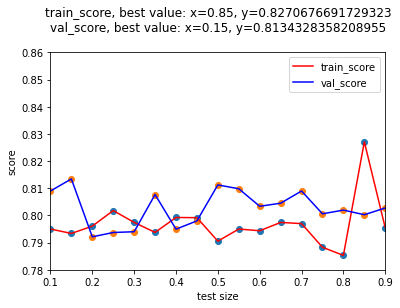

In [ ]:
plot_score_and_loss_by_split(train_no_title,train_survived)

===> 0.2 test size => loss around 7


**Trying without both features**

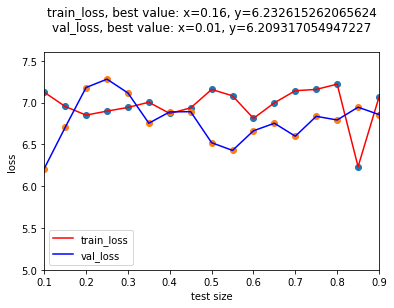

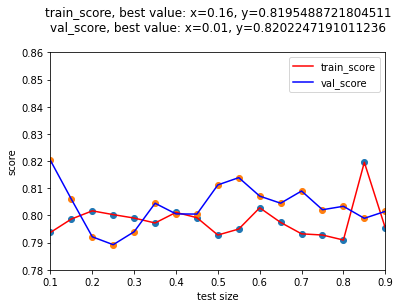

In [ ]:
train_temp = train_no_title.drop("Same_Ticket#", axis=1)
plot_score_and_loss_by_split(train_temp,train_survived)

===> 0.175 test size => loss around 6.9

# It looks like the best model by the validation is with both features.

In [ ]:
X_train = train
t_train = train_survived
X_test = test

In [ ]:
SGD_cls = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.SGDClassifier(loss='log', alpha=0, learning_rate='constant', eta0=0.01)).fit(X_train, t_train)
y_test = SGD_cls.predict(X_test).round(4)

NameError: ignored

In [ ]:
submission = pd.read_csv('/content/gender_submission.csv')
submission['Survived'] = y_test
submission.to_csv('submission.csv', index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


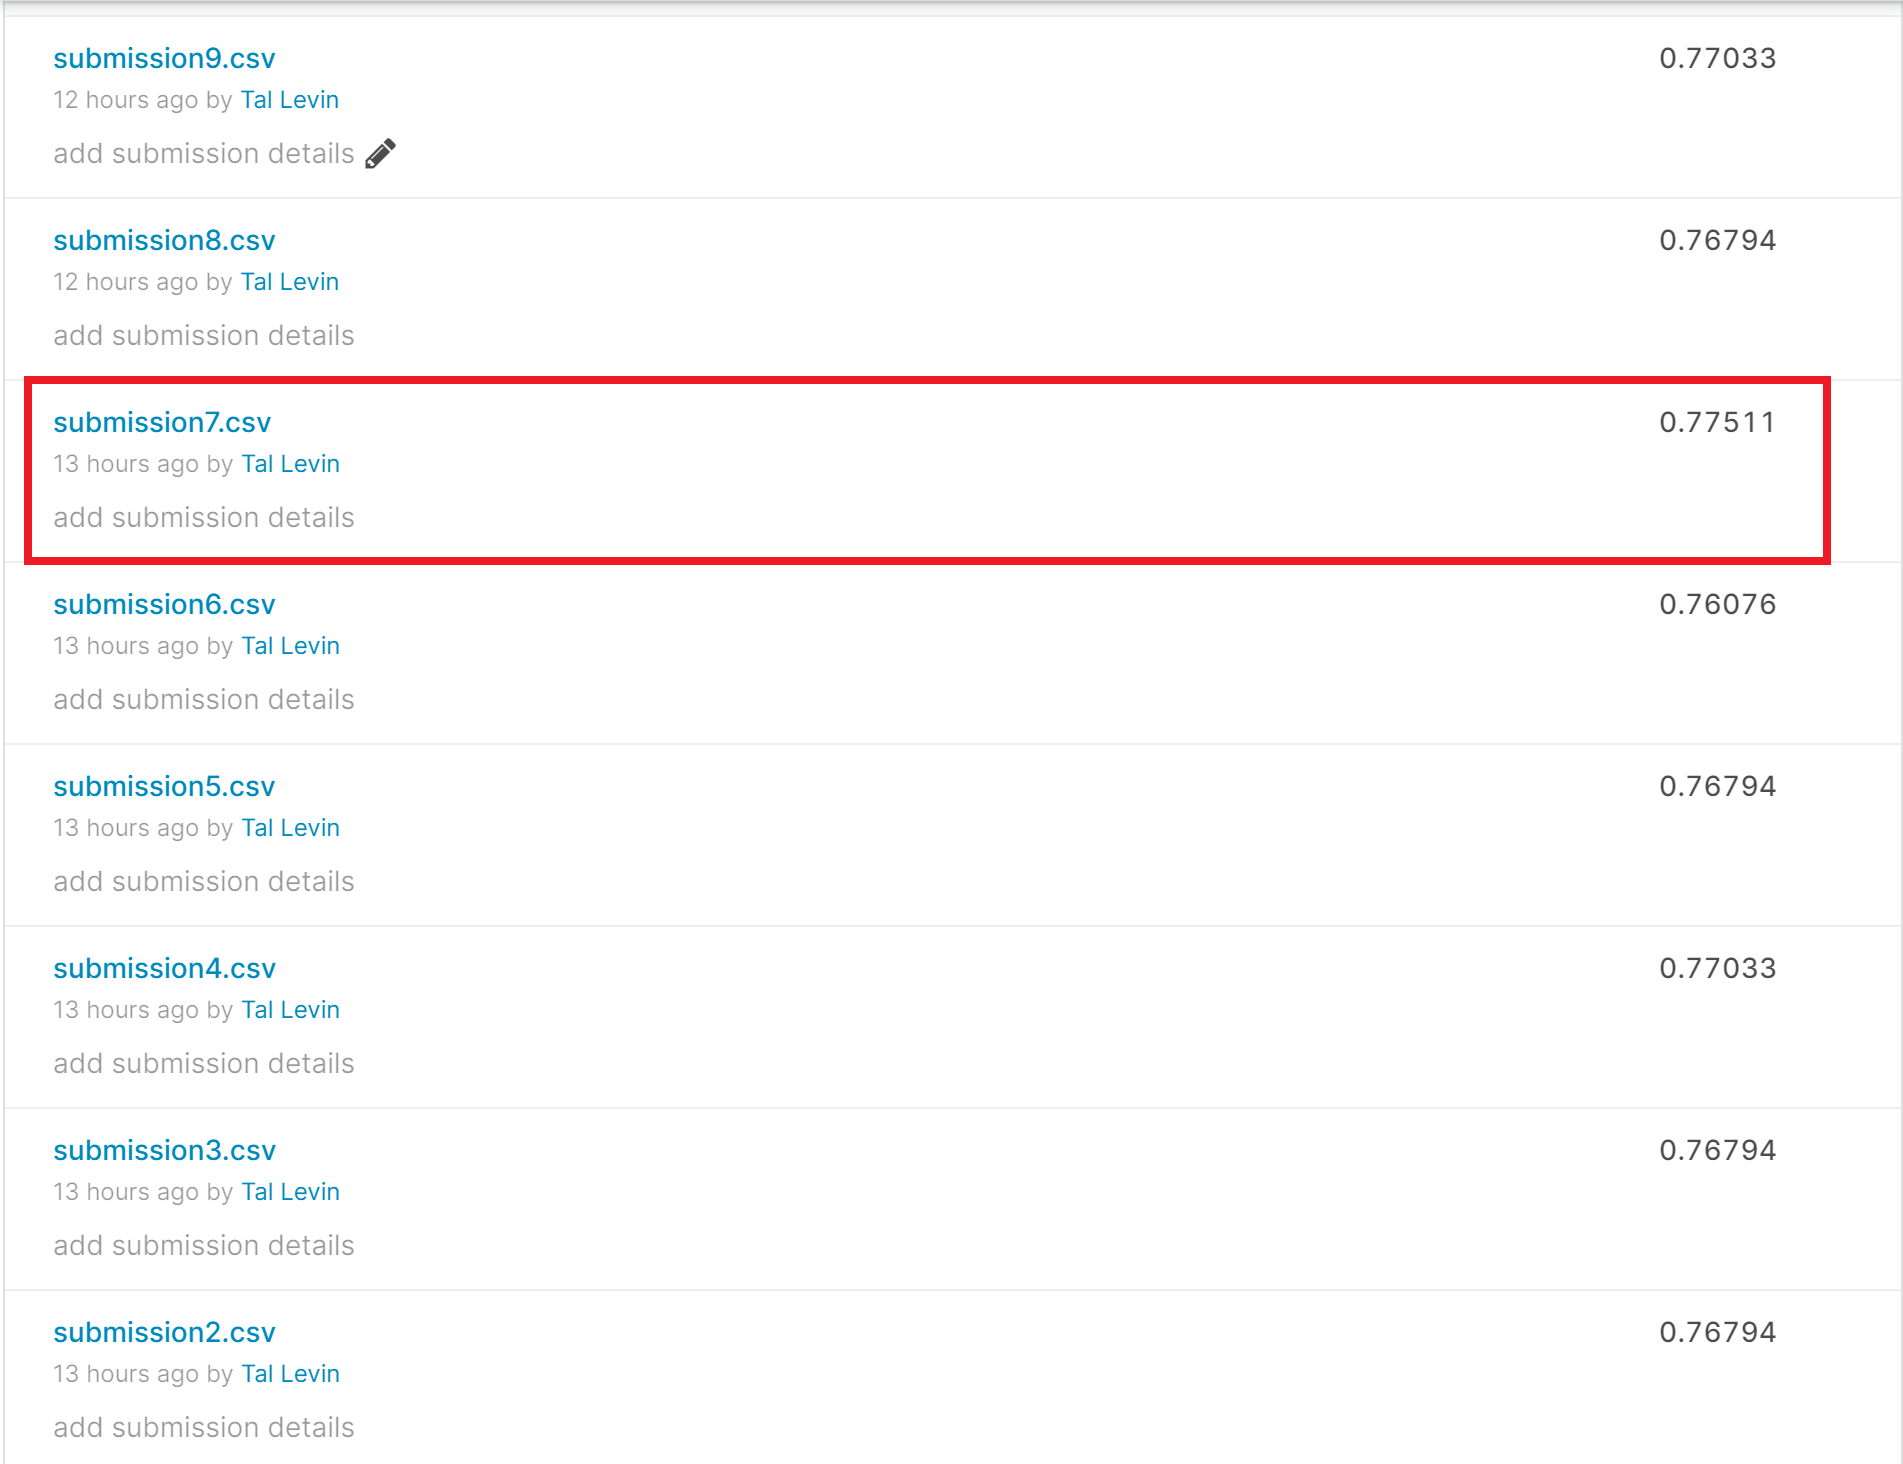

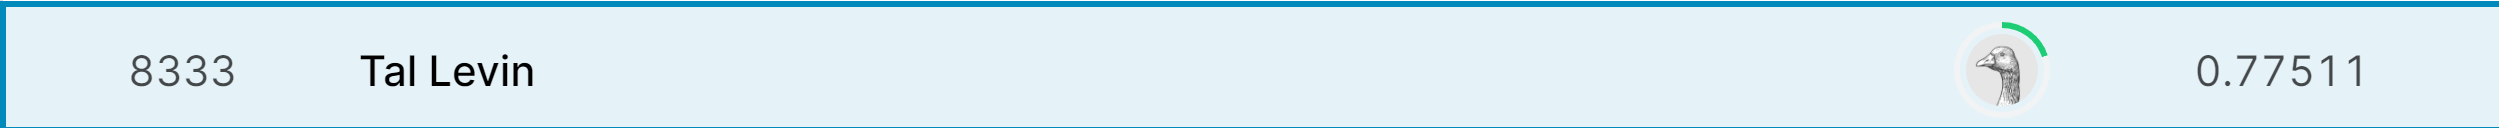

This is the same score as the 4185th place (As of submission time)

# Summary

- Adding Two features: Same_Ticket# and Name_Title
- Filling the missing age values with mean by their name title
- Choosing Logistic Regression with CE loss function as a better fit to this data
- Testing subsets of features on the validation data


**What didn't work:**

There was nothing that I wanted to do that didn't work,
just had a good or bad influence on the result.

# **One more thing:**
**On the validation, the model without the name_title feature is not so good but it gave me the best accuracy score (0.77511) on test.**

# Sources
- https://stackoverflow.com/
- https://www.w3schools.com/
- https://pandas.pydata.org/
- https://scikit-learn.org/stable/index.html
- Our course class' practice notebooks

In [ ]:
%%shell
jupyter nbconvert --to html /content/tal_levin_314920505_titanic_notebook.ipynb

[NbConvertApp] Converting notebook /content/tal_levin_314920505_titanic_notebook.ipynb to html
[NbConvertApp] Writing 1540196 bytes to /content/tal_levin_314920505_titanic_notebook.html
